<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/DLWeek7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import keras_tuner as kt


In [ ]:
file_path = 'ReviewTokoBaju (1).csv'
df = pd.read_csv(file_path)
df.dropna(subset=['Review Text', 'Recommended IND'], inplace=True)

# Data preparation
sentences = df['Review Text'].astype(str).tolist()
labels = df['Recommended IND'].astype(int).tolist()

vocab_size = 10000
oov_tok = ""
max_len = 100

# Tokenizing
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=max_len)

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)


## Training Model

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', 32, 128, step=32)
    ))

    # First RNN layer
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_1', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_1', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Second RNN layer
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_2', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_2', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Third RNN layer
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_3', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_3', [0.2, 0.3, 0.5]),
        return_sequences=False
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        metrics=['accuracy']
    )

    return model

Trial 5 Complete [00h 01m 21s]
val_accuracy: 0.807341992855072

Best val_accuracy So Far: 0.807341992855072
Total elapsed time: 00h 07m 11s
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


566/566 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8169 - loss: 0.4777 - val_accuracy: 0.8207 - val_loss: 0.4707
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8152 - loss: 0.4787 - val_accuracy: 0.8207 - val_loss: 0.4704
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8241 - loss: 0.4657 - val_accuracy: 0.8207 - val_loss: 0.4711
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8112 - loss: 0.4848 - val_accuracy: 0.8207 - val_loss: 0.4708
Epoch 5/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8195 - loss: 0.4729 - val_accuracy: 0.8207 - val_loss: 0.4712
Epoch 6/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8211 - loss: 0.4663 - val_accuracy: 0.8207 - val_loss: 0.4761
Epoch 7/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8197 - loss: 0.4640 - val_accuracy: 0.8207 - val_loss: 0.4881
Epoch 8/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8219 - loss: 0.4479 - val_accurac

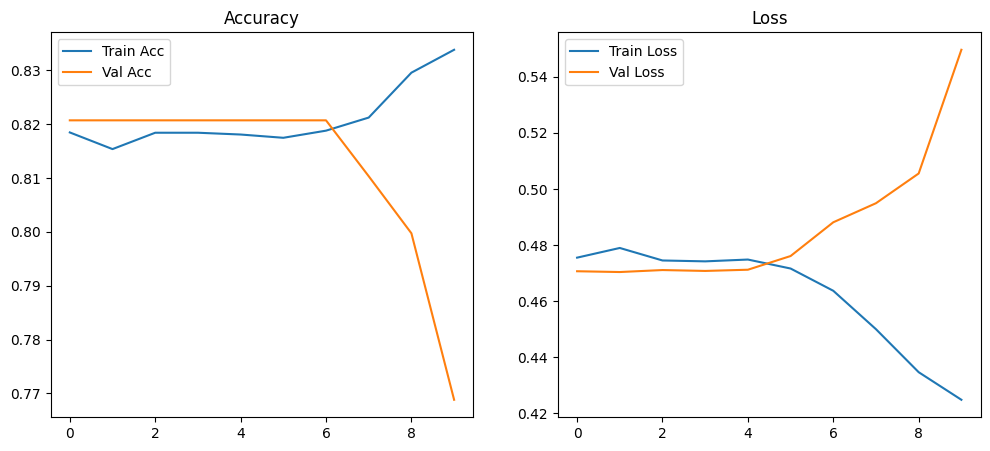

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Akurasi  : 0.7688
Presisi  : 0.8189
Recall   : 0.9222
F1-Score : 0.8675
AUC      : 0.5033


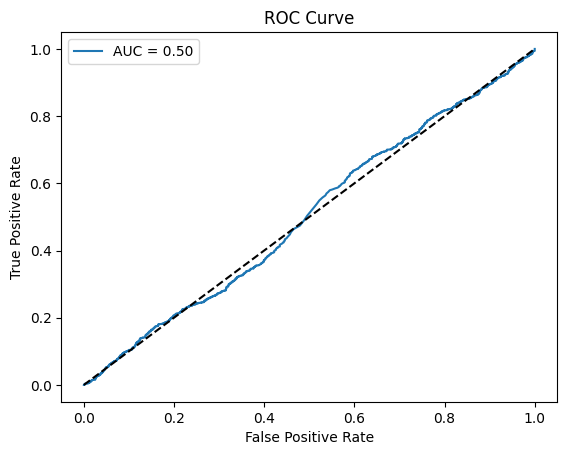

In [ ]:
# Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='deep_rnn_tuner',
    project_name='deep_rnn_review'
)

tuner.search(X_train, np.array(y_train), epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

# Train best model
history = best_model.fit(X_train, np.array(y_train), epochs=10, validation_data=(X_test, np.array(y_test)))

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

# Evaluation
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
